# CMAES : Covariance Matrix Adaptation Evolutionary Strategy

Setup code and utility functions to plot and explore

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d
from numpy.random import multivariate_normal
import copy
from functools import partial

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_context('talk')
    #sns.set(font_scale=1.4)
except ImportError:
    plt.style.use('seaborn-whitegrid')

In [121]:
def range_from_bounds(bounds, resolution):
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)    
    return x_range, y_range

def plot_problem_3d(problem, bounds, ax=None, resolution=100., 
                    cmap=cm.viridis_r, rstride=10, cstride=10, 
                    linewidth=0.15, alpha=0.65):
    """Plots a given benchmark problem in 3D mesh."""
    
    x_range, y_range = range_from_bounds(bounds, resolution=resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = problem(X,Y)

    if not ax:
        fig = plt.figure(figsize=(11,6))
        ax = fig.gca(projection='3d')
        
    cset = ax.plot_surface(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)

In [122]:
def plot_problem_contour(problem, bounds, optimum=None,
                          resolution=100., cmap=cm.viridis_r, 
                          alpha=0.45, ax=None):
    """Plots a given benchmark problem as a countour."""
    x_range, y_range = range_from_bounds(bounds, resolution=resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = problem(X,Y)
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
    
    cset = ax.contourf(X, Y, Z, cmap=cmap, alpha=alpha)
    
    if optimum:
        ax.plot(optimum[0], optimum[1], 'bx', linewidth=4, markersize=15)

In [123]:
def plot_cov_ellipse(pos, cov, volume=.99, ax=None, fc='lightblue', ec='darkblue', alpha=1, lw=1):
    ''' Plots an ellipse that corresponds to a bivariate normal distribution.
    Adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/'''
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':alpha, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)
    ax.add_artist(ellip)

In [124]:
def _rotated_hyper_ellipsoid_impl(x1, x2):
    sqrt3over2 = 3**0.5/2
    return (sqrt3over2*(x1-3) + 0.5*(x2-5))**2 + 5*(sqrt3over2*(x2-5) - 0.5*(x1-3))**2

rotatedhyperellipsoid = partial(_rotated_hyper_ellipsoid_impl)
current_problem = rotatedhyperellipsoid

C:\Users\Jae\AppData\Local\Temp\ipykernel_11956\3429724120.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


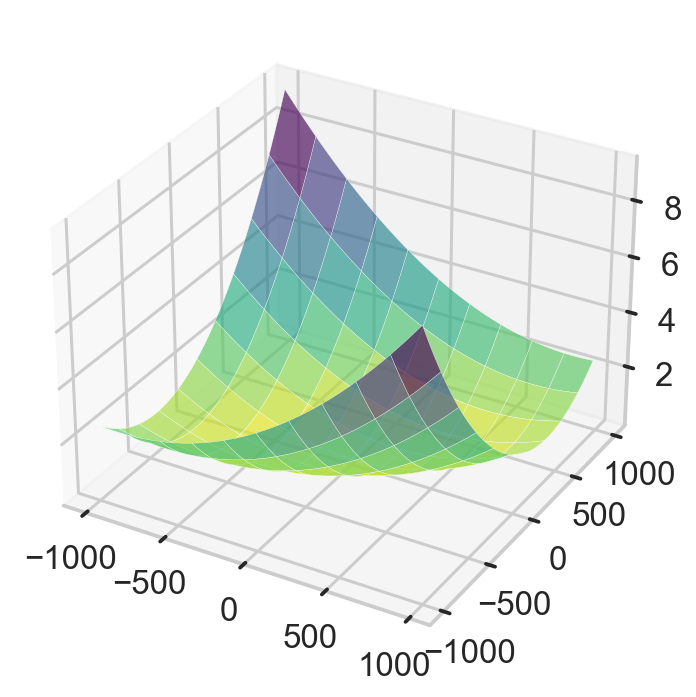

In [125]:
plot_problem_3d(current_problem, ((-1000,-1000), (1000,1000)))

In [126]:
#plot_problem_3d(current_problem, ((-2.5,2.5), (-2.5,2.5)))

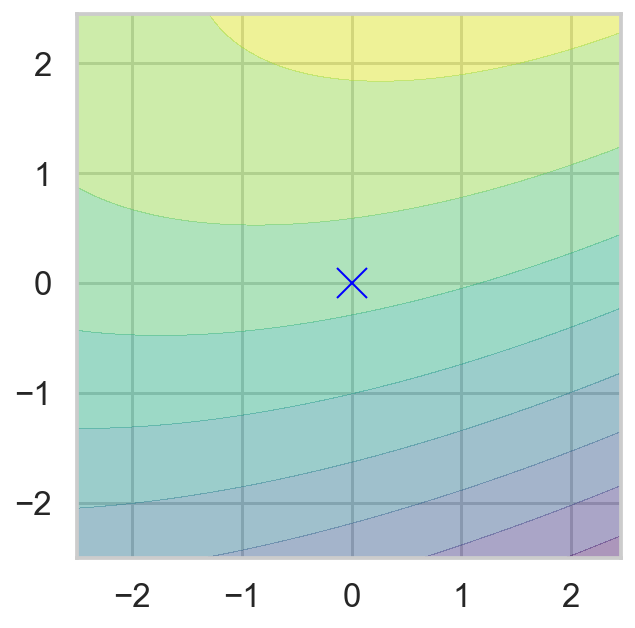

In [127]:
ax = plt.figure(figsize=(8, 5)).gca()
plot_problem_contour(current_problem, ((-2.5,-2.5), (2.5,2.5)), optimum=(0,0), ax=ax)
ax.set_aspect('equal')

In [128]:
class CMAES:
    """Naive CMA implementation"""
    
    def __init__(self, initial_mean, sigma, popsize, **kwargs):
        """Please do all the initialization. The reserve space and 
        code for collecting the statistics are already provided."""

        # Things that evolve : centroid, sigma, paths etc.
        self.centroid = np.asarray(initial_mean).copy()
        self.sigma = sigma
        self.pc = np.zeros_like(initial_mean)
        self.ps = np.zeros_like(initial_mean)        
        self.C = np.eye(initial_mean.shape[0])
        self.B = np.eye(self.C.shape[0])
        self.diagD = np.ones(initial_mean.shape[0])
        
        # Optimal popsize 
        self.popsize = popsize
        self.mu = popsize // 2
        
        # Update weights later on
        # Constant weight policy
        # self.weights = np.ones((self.mu, )) / self.mu

        # Decreasing weight policy
        self.weights = np.arange(self.mu, 0.0, -1.0)
        self.weights /= np.sum(self.weights)
        
        # Negative, Positive weight policy
        # unscaled_weights = np.arange(1.0 ,  1.0 + popsize)
        # unscaled_weights = np.log(0.5 * (popsize + 1.0) / unscaled_weights)

        # Utility variables
        self.dim = initial_mean.shape[0]

        # Expectation of a normal distribution
        self.chiN = np.sqrt(self.dim) * (1.0 - 0.25 / self.dim + 1.0/(21.0 * self.dim**2))
        self.mueff = 1.0 / np.linalg.norm(self.weights, 2)**2
        self.generations = 0
        
        # Options
 
        # Sigma adaptation
        # cs is short for c_sigma
        self.cs = kwargs.get("cs", (2.0 + self.mueff) / (self.dim + self.mueff + 5.0))
        # ds is short for d_sigma
        self.ds = 1.0 + 2.0 * max(0.0, np.sqrt((self.mueff - 1.0)/ (self.dim + 1.0)) - 1.0) + self.cs
        
        # Covariance adaptation
        self.cc = kwargs.get("cc", (4.0 + self.mueff/self.dim) / (self.dim + 4.0 + 2.0 * self.mueff/self.dim))
        self.ccov = 0.0
        # If implementing the latest version of CMA according to the tutorial, 
        # these parameters can be useful
        self.ccov1 = 2.0 / ((self.dim + 1.3)**2 + self.mueff)
        self.ccovmu = min(1.0 - self.ccov1, 2.0 * (self.mueff - 2.0 + 1.0/self.mueff)/((self.dim + 2.0)**2 + self.mueff))
        
        # asserts to guide you
        assert self.dim == 2, "We are dealing with a two-dimensional problem only"
        assert self.centroid.shape == (2,), "Centroid shape is incorrect, did you tranpose it by mistake?"
        assert self.sigma > 0.0, "Sigma is not a non-zero positive number!"
        assert self.pc.shape == (2, ), "pc shape is incorrect, did you tranpose it by mistake?"
        assert self.ps.shape == (2, ), "ps shape is incorrect, did you tranpose it by mistake?"
        assert self.C.shape == (2, 2), "C's shape is incorrect, remember C is a matrix!"     
        assert type(self.popsize) == int, "Population size not an integer"
        assert self.popsize > 0 , "Population size is negative!"
        assert self.popsize > 2 , "Too little population size, make it >2"
        
        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []
    
    def update(self, problem, population):
        """Update the current covariance matrix strategy from the
        *population*.
        
        :param population: A list of individuals from which to update the
                           parameters.
        """
        # -- store current state of the algorithm
        self.stats_centroids.append(copy.deepcopy(self.centroid))
        self.stats_covs.append(copy.deepcopy(self.C))
        
        population.sort(key=lambda ind: problem(*ind))
        # population.sort(key=lambda ind: problem(ind[0], ind[1]))
        # population.sort(key=problem)
        
        # -- store sorted offspring
        self.stats_offspring.append(copy.deepcopy(population))
        
        old_centroid = self.centroid
        # Note : the following does m <- <x>_w
        # Note : this is equivalent to doing m <- m + sigma * <z>_w
        # as x = m + sigma * z provided the weights sum to 1.0 which it
        # does
        self.centroid = np.dot(self.weights, population[0:self.mu])
        
        # -- store new centroid
        self.stats_new_centroids.append(copy.deepcopy(self.centroid))
        
        c_diff = self.centroid - old_centroid
        
        # Cumulation : update evolution path
        # Equivalent to in-class definition
        self.ps = (1 - self.cs) * self.ps \
             + np.sqrt(self.cs * (2 - self.cs) * self.mueff) / self.sigma \
             * np.dot(self.B, (1. / self.diagD) * np.dot(self.B.T, c_diff))
        
        # -- store new evol path
        self.stats_ps.append(copy.deepcopy(self.ps))
        
        hsig = float((np.linalg.norm(self.ps) / 
                np.sqrt(1. - (1. - self.cs)**(2. * (self.generations + 1.))) / self.chiN
                < (1.4 + 2. / (self.dim + 1.))))
        
        self.pc = (1 - self.cc) * self.pc + hsig \
                  * np.sqrt(self.cc * (2 - self.cc) * self.mueff) / self.sigma \
                  * c_diff
        
        # Update covariance matrix
        artmp = population[0:self.mu] - old_centroid
        self.C = (1 - self.ccov1 - self.ccovmu + (1 - hsig) \
                   * self.ccov1 * self.cc * (2 - self.cc)) * self.C \
                + self.ccov1 * np.outer(self.pc, self.pc) \
                + self.ccovmu * np.dot((self.weights * artmp.T), artmp) \
                / self.sigma**2
        
        # -- store new covs
        self.stats_new_covs.append(copy.deepcopy(self.C))
        
        self.sigma *= np.exp((np.linalg.norm(self.ps) / self.chiN - 1.) \
                                * self.cs / self.ds)
        
        self.diagD, self.B = np.linalg.eigh(self.C)
        indx = np.argsort(self.diagD)
        
        self.cond = self.diagD[indx[-1]]/self.diagD[indx[0]]
        
        self.diagD = self.diagD[indx]**0.5
        self.B = self.B[:, indx]
        self.BD = self.B * self.diagD
        
    def run(self, problem):
        # At the start, clear all stored cache and start a new campaign
        self.reset()
        
        while self.generations < 40:
            # Sample the population here!
            population = list(multivariate_normal(self.centroid, self.sigma**2 * self.C, self.popsize))

            # Pass the population to update, which computes all new parameters 
            self.update(problem, population)
            # print(np.array(population).shape)
            self.generations += 1
        else:
            return population[0]
        
    def reset(self):
        # Clears everything to rerun the problem
        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []

In [129]:
initial_centroid = np.random.randn(2, )
cma_es = CMAES(initial_centroid, 0.6, 100)

In [130]:
final_array = cma_es.run(current_problem)
final_fitness = rotatedhyperellipsoid(final_array[0],final_array[1])
print(final_array)
print(final_fitness)

[3. 5.]
4.039033503720948e-23


In [131]:
normalizer = colors.Normalize(vmin=np.min(cma_es.weights), vmax=np.max(cma_es.weights))
sm = cm.ScalarMappable(norm=normalizer, cmap=plt.get_cmap('gray'))

In [132]:
from matplotlib import animation
from IPython.display import HTML

In [133]:
def animate_cma_es(gen):
    ax.cla()
    plot_problem_contour(current_problem, ((-11,-11), (11,11)), optimum=(0,0), ax=ax)
    
    plot_cov_ellipse(cma_es.stats_centroids[gen], cma_es.stats_covs[gen], volume=0.99, alpha=0.29, 
                     fc='red', ec='darkred',
                     ax=ax)
    ax.plot(cma_es.stats_centroids[gen][0], cma_es.stats_centroids[gen][1], 'ro', markeredgecolor = 'none', ms=10)
    
    plot_cov_ellipse(cma_es.stats_new_centroids[gen], cma_es.stats_new_covs[gen], volume=0.99, 
                     alpha=0.29, fc='green', ec='darkgreen', ax=ax)
    ax.plot(cma_es.stats_new_centroids[gen][0], cma_es.stats_new_centroids[gen][1], 'go', markeredgecolor = 'none', ms=10)
    
    for i in range(gen+1):
        if i == 0:
            ax.plot((0,cma_es.stats_ps[i][0]),
                     (0,cma_es.stats_ps[i][1]), 'b--')
        else:
            ax.plot((cma_es.stats_ps[i-1][0],cma_es.stats_ps[i][0]),
                     (cma_es.stats_ps[i-1][1],cma_es.stats_ps[i][1]),'b--')
            
    for i,ind in enumerate(cma_es.stats_offspring[gen]):
        if i < len(cma_es.weights):
            color = sm.to_rgba(cma_es.weights[i])
        else:
            color= sm.to_rgba(normalizer.vmin)
        ax.plot(ind[0], ind[1], 'o', color = color, ms=5, markeredgecolor = 'none')
    
    ax.set_ylim((-10,10))
    ax.set_xlim((-10,10))
    ax.set_title('$generation=$' +str(gen))
    return []

In [134]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
anim = animation.FuncAnimation(fig, animate_cma_es, frames=cma_es.generations, interval=300, blit=True)
plt.close()

In [135]:
HTML(anim.to_html5_video())